In [1]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random
from random import shuffle
from random import randint

In [2]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [3]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005
flareperiod = 4096
flarecycles = 10
dayinsec=86400
background = 40
# sat mag u,g,r,i,z,y=14.7,15.7,15.8,15.8,15.3 and 13.9
# start date 59580.033829 end date + 10 years

In [4]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty
#from lsst should have got the website! https://smtn-002.lsst.io/

In [5]:
magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   

287210299.76535374

In [6]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])



In [7]:
def remove25(observations):
    global obs
    Startdate = 59580
    EndDate = Startdate + (365.25*10)
    surveyDuration = EndDate - Startdate
    print(Startdate,EndDate)
    randomstart = randint(0,75)
    exclusionStart = Startdate + (randomstart*(surveyDuration)*0.01)
    exclusionEnd = exclusionStart+(0.25*(surveyDuration))
    print(exclusionStart,exclusionEnd)
    for x in range(0,len(obs)):
        obs[x] = [y for y in obs[x] if y > exclusionEnd or y < exclusionStart]        

In [8]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [9]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds/(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

def Flux(observations,Frequency,exptime):
    a = [np.sin((2*np.pi*(Frequency*0.01)*x)) for x in observations]
    return a

In [10]:
observations = [1,2,3,4,5]
Frequency = 30
exptime = 30
b = [0]*len(observations)
for seconds in range(0, exptime):
    a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds/(3600*24)))) for x in observations] # optical modulation
    b = map(add, a, b)
c = [z/exptime for z in b]
average = c
nonaverage = [np.sin((2*np.pi*(Frequency*0.01)*(x-observations[0]))) for x in observations]
print(average, nonaverage)

([0.0, 0.95105651629515364, -0.58778525229247325, -0.58778525229247336, 0.95105651629515353], [0.0, 0.95105651629515364, -0.58778525229247303, -0.58778525229247336, 0.95105651629515353])


In [11]:
def flaring(B, length, dayinsec=86400,amplitude=1):   
    global flareMag, minutes
    fouriers = np.linspace(0.00001,0.05,(dayinsec/30))
    logF = [np.log(x) for x in fouriers] # start at 30 go to a day in 30 sec increments
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers] #random.gauss(mu,sigma) to change for values from zurita
    # imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,dayinsec, (dayinsec/30))
    minutes = [x for x in seconds]
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT] # what did this even achieve? it helped with normalisation!
    normalised = [x/(np.mean(positive)) for x in positive] # find normalisation
    normalisedmin = minimum/(np.mean(positive))
    normalised = [x - normalisedmin for x in normalised]
    flareMag = [amplitude * x for x in normalised] # normalise to amplitude
#     logmins = [np.log(d) for d in minutes] # for plotting?
#     plt.plot(minutes,flareMag)
#     plt.title('lightcurve')
#     plt.show()
    return flareMag

/home/mj1e16/.local/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


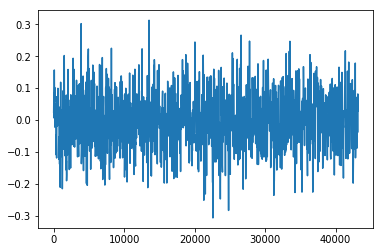

In [12]:
longflare = []
for floop in range(0,5):
    flareone = flaring(-1, flareperiod, amplitude=0.3)
    flareone = flareone[0:1440]
    longflare.append(flareone)
minutes = minutes[0:1440]
plt.plot(minutes, longflare[1])
#plt.xlim(100,400)
plt.show()

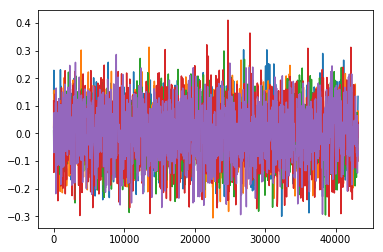

In [13]:
for x in range(0,5):
    plt.plot(minutes, longflare[x])
plt.show()

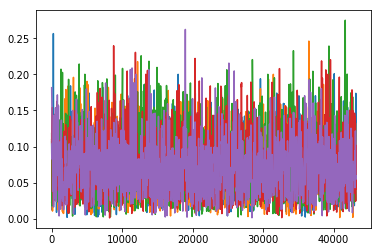

In [17]:
#positivelongflare = [abs(x) for x in longflare]
#positiveflare = [abs(x) for x in flare]

longflare = []
for floop in range(0,5):
    flareone = flaring(-1, flareperiod, amplitude=0.2)
    flareone = flareone[0:1440]
    positiveflare = [abs(x) for x in flareone]
    longflare.append(positiveflare)
    minutes = minutes[0:1440]
    plt.plot(minutes, longflare[floop])
plt.show()

In [18]:
# longstarflare = [23 - x for x in longflare[0]]
# flux = [(10**(-2.5*x))*(10**59) for x in longstarflare]
# average = (10**(-2.5*23))*(10**59)
# print(average)
# print(flux[100])
# flareonly = [x - average for x in flux]
# print(flareonly[0])
# meanflux=np.mean(flareonly)
# print(meanflux,average)
# relativemean = meanflux/average
# std = np.std(longstarflare)
# print('mean',relativemean,'std',std)

In [19]:
np.mean(longflare)

0.075829956295538806

In [20]:
np.std(longflare)

0.039857651505171746

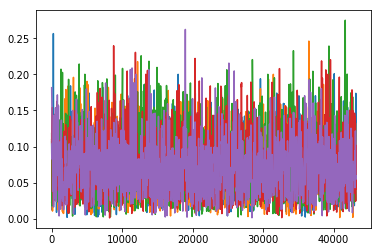

In [21]:
for x in range(0,5):
    plt.plot(minutes, longflare[x])
plt.show()

In [22]:
def confidenceLevel(numsteps): # no sigma clipping?
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > numsteps:
        sigma = np.std(power[(position-numsteps):(position+numsteps)])
        mean = np.mean(power[(position-numsteps):(position+numsteps)])
    else:
        sigma = np.std(power[0:(position+numsteps)])
        mean = np.mean(power[0:(position+numsteps)])
    confidence = mean + (5*sigma)
    return confidence

In [23]:
# def fullGraph(objectmag,frequency,flareAmp=0.1,modulationAmplitude=0.1,lower=0,higher=3500,ramp=1,background=40): # ramp controls graularity of time
#     global Zmag, dayZ, Zbasic
#     minutesnotindays = np.linspace(0,(175320),175321)# 10 years in 30 minute intervals#np.linspace(0,87660,87661) #np.linspace(0,5259600,5259601)
#     Minutes = [(h/(24*2)) for h in minutesnotindays] # 4 24 24*60
#     #allobsz, uobsz, gobsz, robsz, iobsz, zobsz, yobsz = [], [], [], [], [], [], [] #reset
#     #Z = [allobz, uobsz, gobsz, robsz, iobsz, zobsz, yobsz]
#     Z = [[],[],[],[],[],[],[]]
#     Zbasic = [[],[],[],[],[],[],[]]
    
#     for x in range(1,len(Z)):
#         Z[x] = Flux(Minutes, frequency, 30)  # amplitde calculation for observations, and frequency range
#     for x in range(1,len(Z)):
#         Z[x] = [modulationAmplitude * t for t in Z[x]]
# #     for x in range(0,len(Z)):
    
#     for x in range(1,len(Z)):
#         Zbasic[x] = [t + objectmag[x] for t in Z[x]]
    
#     for x in range(1,len(Z)):
#         for G in range(1, len(Z)):
#             flareMinute = int(round(minutesnotindays[G]*60)%((dayinsec/30)*flarecycles)) # find array number for flaring
#             if flareMinute == ((dayinsec/30)*flarecycles):
#                 flareMinute = ((dayinsec/30)*flarecycles) - 1
#             Z[x][G] = Z[x][G] - longflare[flareMinute]
    
#     Zmag = [[],[],[],[],[],[],[]]
#     for x in range(1,len(Z)):
#         #amplitude = [t-random.gauss(0,magUncertainy(zeroPoints[x],objectmag[x],30,background,FWHMeff[x])) for t in Z[x]] # scale amplitude and add poisson noise         
#         amplitude = [t for t in Z[x]]
#         Zmag[x] = [t + objectmag[x] for t in amplitude]
#     dayZ = [t for t in Minutes]
        

#     plt.plot(dayZ,Zmag[1])
#     plt.xlim(lower,higher)
#     plt.xlabel('time')
#     plt.ylabel('mag')
#     plt.show()


In [24]:
def fullGraph(objectmag,frequency,flareAmp=0.1,modulationAmplitude=0.1,lower=0,higher=3500,ramp=1): # ramp controls graularity of time
    global Zmag, dayZ, Zbasic
    minutesnotindays = np.linspace(0,(175320),175321)# 10 years in 30 minute intervals#np.linspace(0,87660,87661) #np.linspace(0,5259600,5259601)
    Minutes = [(h/(24*2)) for h in minutesnotindays] # 4 24 24*60
    Z = []
    Z = Flux(Minutes, frequency, 30)  # amplitde calculation for observations, and frequency range
    Z = [modulationAmplitude * t for t in Z]
    Zbasic = [t + objectmag for t in Z]
    for G in range(0, len(Z)):
        #flareMinute = int(round((Z[G]*24*60*2)%(dayinsec*10*flarecycles)))
        flareMinute = int(round(minutesnotindays[G]*60)%((dayinsec/60)*flarecycles)) # find array number for flaring
        if flareMinute == ((dayinsec/30)*flarecycles):
            flareMinute = ((dayinsec/30)*flarecycles) - 1
        Z[G] = Z[G] - longflare[flareMinute]

    Zamplitude = [t-random.gauss(0,magUncertainy(zeroPoints[4],objectmag[4],30,background,FWHMeff[4])) for t in Z] # scale amplitude and add poisson noise         
    #Zamplitude = [t for t in Z]
    Zmag = [t + objectmag for t in Zamplitude]
    dayZ = [t for t in Minutes]

    plt.plot(dayZ,Zmag)
    plt.xlim(lower,higher)
    plt.xlabel('time')
    plt.ylabel('mag')
    plt.show()


In [25]:
def lombScargleAuto(frequencyRange,objectmag,lower=0,higher=3500,loopNo=1,numsteps=100000,modulationAmplitude=0.1,Nquist=200): # frequency range and object mag in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency, periods, LSperiod, power, mag, error, SigLevel
    totperiod = [[],[],[],[],[],[]]
    totmperiod = [[],[],[],[],[],[]]
    totpower = [[],[],[],[],[],[]] # reset
    SigLevel = [[],[],[],[],[],[]]
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset

        measuredpower = [] # reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # taken average out # amplitde calculation for observations, and frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]            
        for z in range(1,len(y)):
            for G in range(0, len(y[z])):
                flareMinute = int(round((obs[z][G]*24*60*2)%((dayinsec/60)*flarecycles)))
                y[z][G] = y[z][G] - longflare[flareMinute]
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t-random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            #amplitude = [t for t in y[z]]            
            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
                        
            #curve and observations
            plt.plot(dayZ,Zmag)
            plt.plot(dayZ,Zbasic)
            plt.plot(date, mag, 'o')
            plt.xlim(lower,higher)
            plt.xlabel('time (days)')
            plt.ylabel('mag')
            plt.gca().invert_yaxis()
            plt.show()
            
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)
            
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
            fig, ax = plt.subplots()
            ax.plot(periods, power)
            #plt.plot([0,10],[fiveSig,fiveSig])
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            period = 100./(frequencyRange[frange])
            phase = [(day.value % (period*2))/(period*2) for day in date]
            idealphase = [(day % (period*2))/(period*2) for day in dayZ]
            
            plt.plot(idealphase,Zmag,'ko',)
            plt.plot(phase, mag, 'yo', markersize=4)
            
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.show()
            print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
            print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min(),power.max())# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
            
            totperiod[z-1].append(1/(frequencyRange[frange]*0.01))
            totmperiod[z-1].append(np.mean(LSperiod))
            totpower[z-1].append(power.max())
            
            measuredpower.append(power.max())
            maxpower = []
            counter = 0.
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                periods, power = model.periodogram_auto(nyquist_factor=Nquist)
                maxpower.append(power.max())
                
            for X in range(0, len(maxpower)):
                if maxpower[X] > measuredpower[z-1]:
                    counter = counter + 1. 
            Significance = (1.-(counter/len(maxpower)))
            print('sig', Significance, 'counter', counter)
            SigLevel[z-1].append(Significance)


In [26]:
def lombScargle(frequencyRange,objectmag,loopNo=1,df=0.001,fmin=0.001,numsteps=100000,modulationAmplitude=0.1,Nquist=200): # frequency range and object mag in list
    global totperiod, totmperiod, totpower, date, amplitude, frequency, periods, LSperiod, power, mag, error, SigLevel
    totperiod = [[],[],[],[],[],[]]
    totmperiod = [[],[],[],[],[],[]]
    totpower = [[],[],[],[],[],[]] # reset
    SigLevel = [[],[],[],[],[],[]]
    freqs = fmin + df * np.arange(numsteps) # for manuel
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        measuredpower = [] # reset
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]] # scaling
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int(round((obs[z][G]*24*60*2)%((dayinsec/60)*flarecycles)))
                y[z][G] = y[z][G] - longflare[flareMinute] # add flares swapped to second but not changing the name intrtoduces fewer bugs
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            mag = [t + objectmag[z] for t in amplitude] # add actual mag
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
#             #curve and observations
#             plt.plot(dayZ,Zmag)
#             plt.plot(dayZ,Zbasic)
#             plt.plot(date, mag, 'o')
#             #plt.xlim(lower,higher)
#             plt.xlabel('time (days)')
#             plt.ylabel('mag')
#             plt.gca().invert_yaxis()
#             plt.show()
                     
            model = LombScargleFast().fit(date, mag, error)
            power = model.score_frequency_grid(fmin, df, numsteps)  
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
#             fig, ax = plt.subplots()
#             ax.plot(1./freqs, power)
#             ax.set(xlim=(0, 10), ylim=(0, 1.2),
#                    xlabel='period (days)',
#                    ylabel='Lomb-Scargle Power');
#             plt.show()

#             period = 100./(frequencyRange[frange])
#             phase = [(day.value % (period*2))/(period*2) for day in date]
#             idealphase = [(day % (period*2))/(period*2) for day in dayZ]
#             plt.plot(idealphase,Zmag,'ko',)
#             plt.plot(phase, mag, 'yo', markersize=4)
#             plt.xlabel('Phase')
#             plt.ylabel('Magnitude')
#             plt.gca().invert_yaxis()
#             plt.show()
            
#             print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
#             print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min(),power.max())# 'power',np.mean(power[maxpos]))
#             print(frequencyRange[frange])
            
#             print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min(),power.max())# 'power',np.mean(power[maxpos]))
#             print(frequencyRange[frange], 'z', z)
                  
            totperiod[z-1].append(1/(frequencyRange[frange]*0.01))
            totmperiod[z-1].append(np.mean(LSperiod))
            totpower[z-1].append(power.max())
            
            measuredpower.append(power.max())
            maxpower = []           
            counter = 0.
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                power = model.score_frequency_grid(fmin, df, numsteps)  
                maxpower.append(power.max())
                

            for X in range(0, len(maxpower)):
                if maxpower[X] > measuredpower[-1]:
                    counter = counter + 1. 
            Significance = (1.-(counter/len(maxpower)))
            # print('sig', Significance, 'counter', counter)
            SigLevel[z-1].append(Significance)
            

In [24]:
findObservations([(630,)])
remove25(obs)
averageFlux(obs[0], 1, 30)
longflare = []
for floop in range(0,flarecycles):
    flareone = flaring(-1, flareperiod, amplitude=0.3)
    flareone = flareone[0:1440]
    positiveflare = [abs(x) for x in flareone]
    longflare.extend(positiveflare)

(59580, 63232.5)
(61844.55, 62757.675)


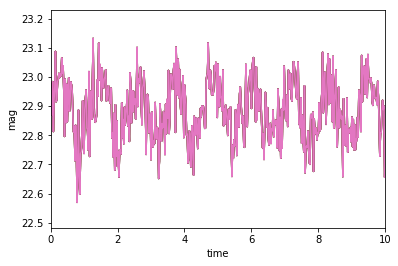

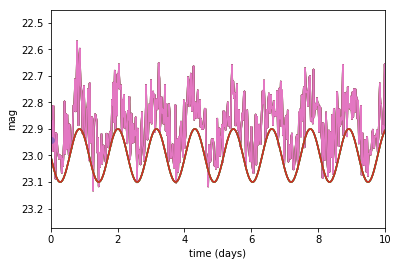

Finding optimal frequency:
 - Estimated peak width = 0.0025
 - Using 5 steps per peak; omega_step = 0.0005
 - User-specified period range:  0.01 to 10
 - Computing periods at 1254242 steps


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


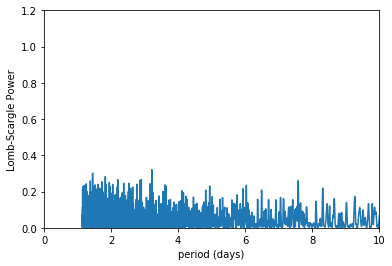

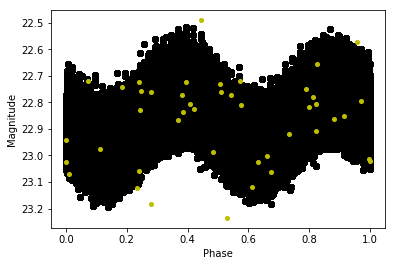

('actualperiod', 1.1494252873563218, 'measured period', 0.019958576117297615) ('actualperiod', 1.1494252873563218, 'measured period', 0.019958576117297615, 1.1413598354545453, 0.32068860966234486)
87
('sig', 0.0, 'counter', 1.0)


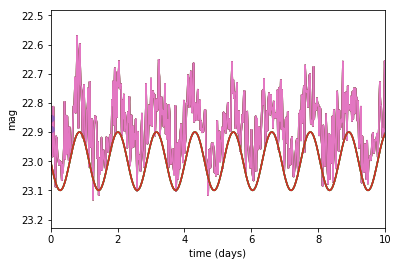

Finding optimal frequency:
 - Estimated peak width = 0.00244
 - Using 5 steps per peak; omega_step = 0.000488
 - User-specified period range:  0.01 to 10
 - Computing periods at 1286169 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


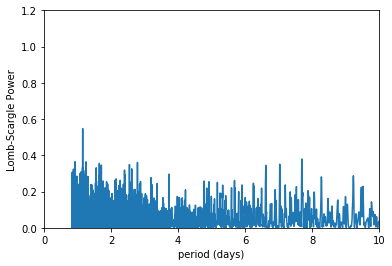

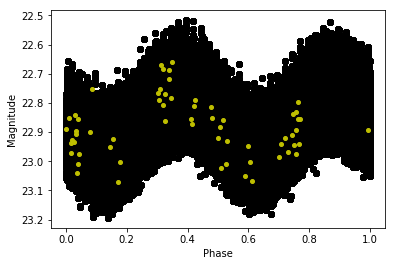

('actualperiod', 1.1494252873563218, 'measured period', 1.1494520034359106) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494520034359106, 0.83061586387096598, 0.54777684920834269)
87
('sig', 1.0, 'counter', 0.0)


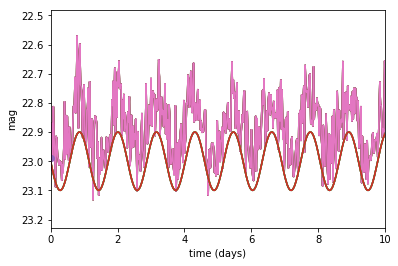

Finding optimal frequency:
 - Estimated peak width = 0.00239
 - Using 5 steps per peak; omega_step = 0.000478
 - User-specified period range:  0.01 to 10
 - Computing periods at 1314042 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


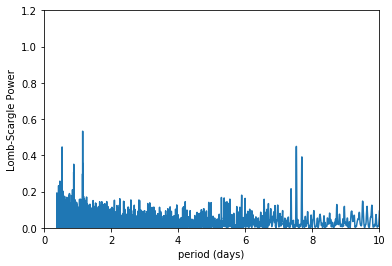

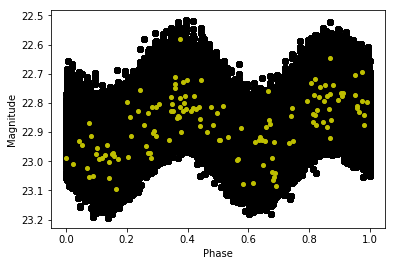

('actualperiod', 1.1494252873563218, 'measured period', 1.1494591638034877) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494591638034877, 0.37851956503597162, 0.53315405380594028)
87
('sig', 1.0, 'counter', 0.0)


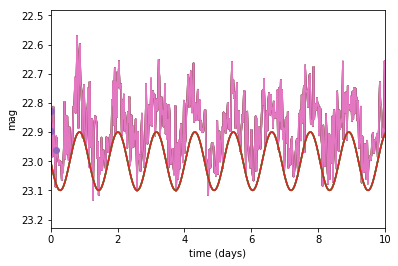

Finding optimal frequency:
 - Estimated peak width = 0.00244
 - Using 5 steps per peak; omega_step = 0.000487
 - User-specified period range:  0.01 to 10
 - Computing periods at 1288203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


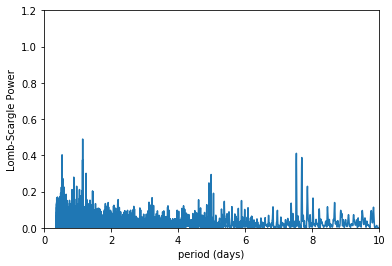

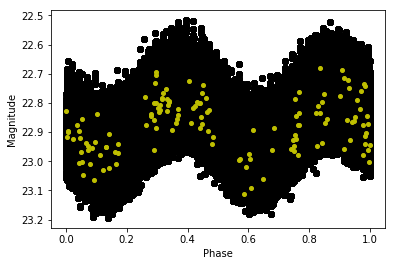

('actualperiod', 1.1494252873563218, 'measured period', 1.1494322865705027) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494322865705027, 0.37107645755395752, 0.48970724723117698)
87
('sig', 1.0, 'counter', 0.0)


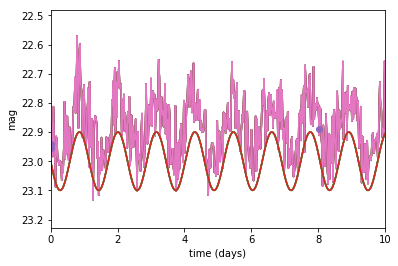

Finding optimal frequency:
 - Estimated peak width = 0.0024
 - Using 5 steps per peak; omega_step = 0.00048
 - User-specified period range:  0.01 to 10
 - Computing periods at 1307104 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


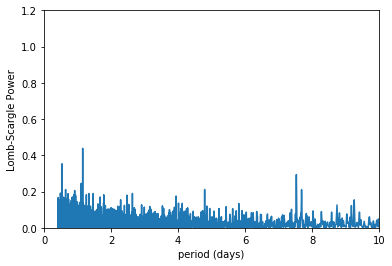

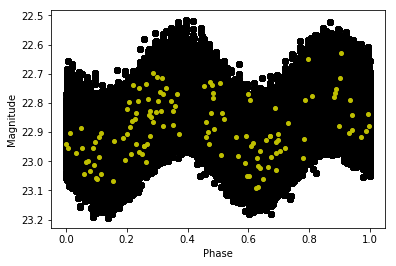

('actualperiod', 1.1494252873563218, 'measured period', 1.1494339749699347) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494339749699347, 0.40570889100775098, 0.43864329001685226)
87
('sig', 1.0, 'counter', 0.0)


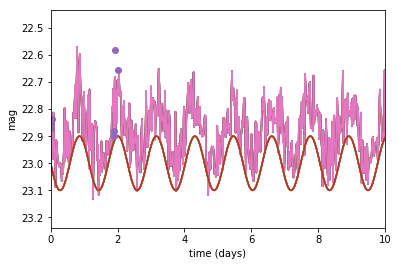

Finding optimal frequency:
 - Estimated peak width = 0.00239
 - Using 5 steps per peak; omega_step = 0.000478
 - User-specified period range:  0.01 to 10
 - Computing periods at 1314065 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


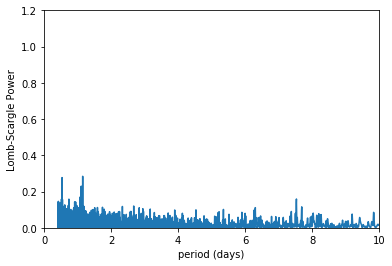

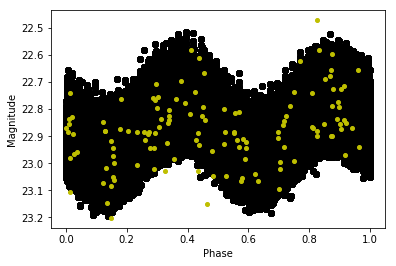

('actualperiod', 1.1494252873563218, 'measured period', 1.1494112708321402) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494112708321402, 0.40473208584615411, 0.28424607995392992)
87
('sig', 1.0, 'counter', 0.0)


In [25]:
# actual frequency = frquency/100
fullGraph([23]*7,87,lower=0,higher=10,ramp=10)
lombScargleAuto([87],([23]*7),Nquist=100,lower=0,higher=10)
 # 40 background corresponing to R band at new moon, could be made more detailed?

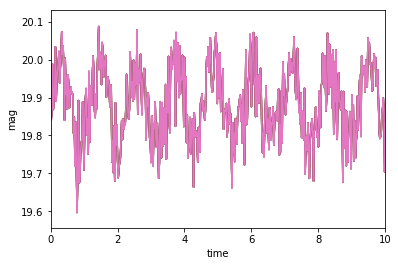

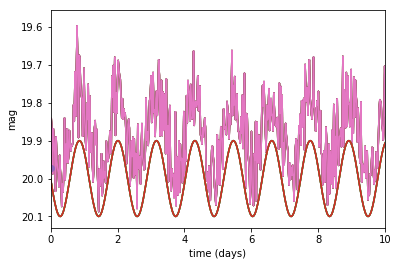

Finding optimal frequency:
 - Estimated peak width = 0.0025
 - Using 5 steps per peak; omega_step = 0.0005
 - User-specified period range:  0.01 to 10
 - Computing periods at 1254242 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


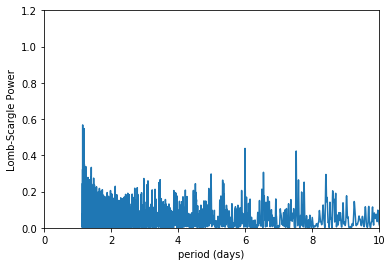

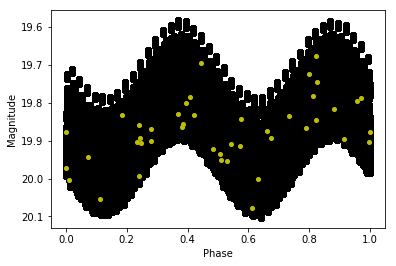

('actualperiod', 1.1494252873563218, 'measured period', 1.1495355602808257) ('actualperiod', 1.1494252873563218, 'measured period', 1.1495355602808257, 1.1413598354545453, 0.5676993796585118)
87
('sig', 1.0, 'counter', 0.0)


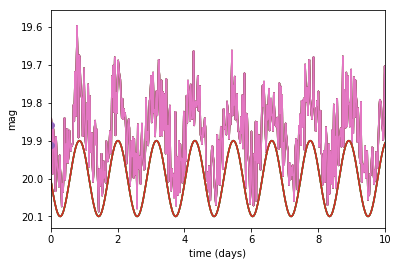

Finding optimal frequency:
 - Estimated peak width = 0.00244
 - Using 5 steps per peak; omega_step = 0.000488
 - User-specified period range:  0.01 to 10
 - Computing periods at 1286169 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


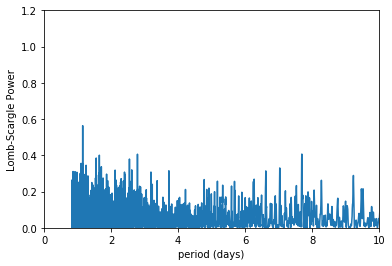

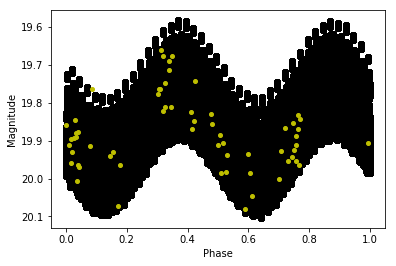

('actualperiod', 1.1494252873563218, 'measured period', 1.1494622659470373) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494622659470373, 0.83061586387096598, 0.56368722494965107)
87
('sig', 1.0, 'counter', 0.0)


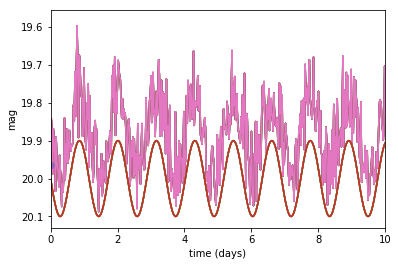

Finding optimal frequency:
 - Estimated peak width = 0.00239
 - Using 5 steps per peak; omega_step = 0.000478
 - User-specified period range:  0.01 to 10
 - Computing periods at 1314042 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


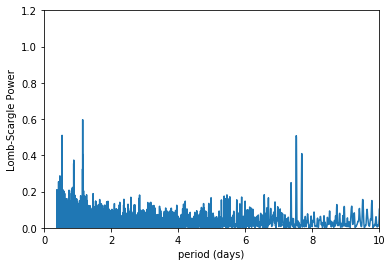

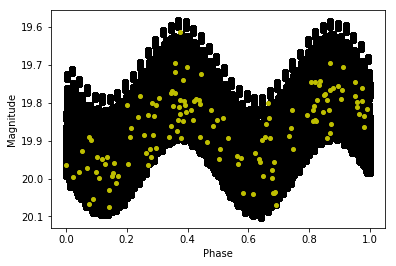

('actualperiod', 1.1494252873563218, 'measured period', 1.1494631817621286) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494631817621286, 0.37851956503597162, 0.59655934183311077)
87
('sig', 1.0, 'counter', 0.0)


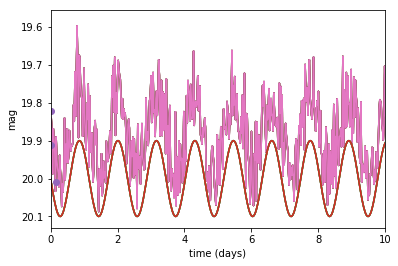

Finding optimal frequency:
 - Estimated peak width = 0.00244
 - Using 5 steps per peak; omega_step = 0.000487
 - User-specified period range:  0.01 to 10
 - Computing periods at 1288203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


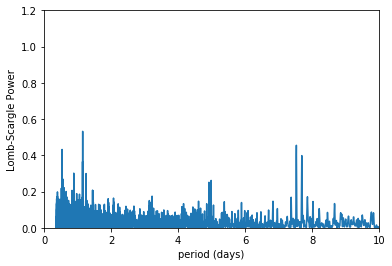

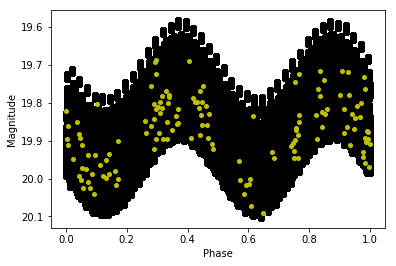

('actualperiod', 1.1494252873563218, 'measured period', 1.1494230653671762) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494230653671762, 0.37107645755395752, 0.53246249317444327)
87
('sig', 1.0, 'counter', 0.0)


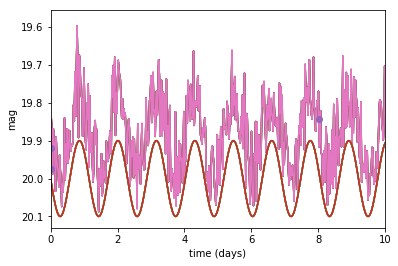

Finding optimal frequency:
 - Estimated peak width = 0.0024
 - Using 5 steps per peak; omega_step = 0.00048
 - User-specified period range:  0.01 to 10
 - Computing periods at 1307104 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


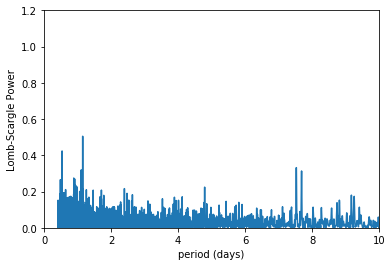

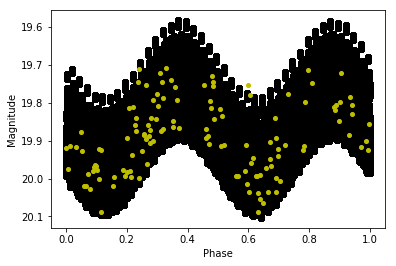

('actualperiod', 1.1494252873563218, 'measured period', 1.149453160979891) ('actualperiod', 1.1494252873563218, 'measured period', 1.149453160979891, 0.40570889100775098, 0.50518562849810911)
87
('sig', 1.0, 'counter', 0.0)


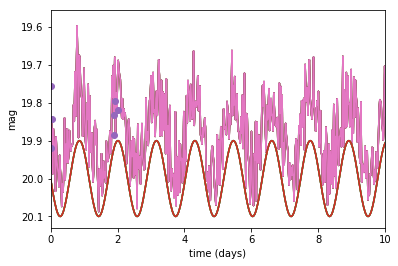

Finding optimal frequency:
 - Estimated peak width = 0.00239
 - Using 5 steps per peak; omega_step = 0.000478
 - User-specified period range:  0.01 to 10
 - Computing periods at 1314065 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


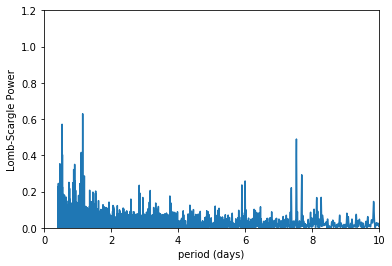

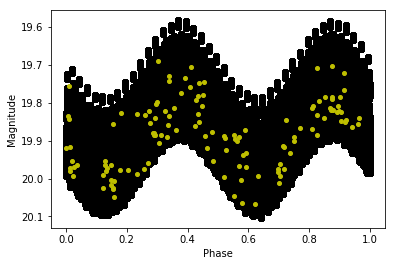

('actualperiod', 1.1494252873563218, 'measured period', 1.1493941965530261) ('actualperiod', 1.1494252873563218, 'measured period', 1.1493941965530261, 0.40473208584615411, 0.62936662135595844)
87
('sig', 1.0, 'counter', 0.0)


In [26]:
# actual frequency = frquency/100
fullGraph([20]*7,87,lower=0,higher=10,ramp=10)
lombScargleAuto([87],([20]*7),Nquist=100,lower=0,higher=10)
 # 40 background corresponing to R band at new moon, could be made more detailed?

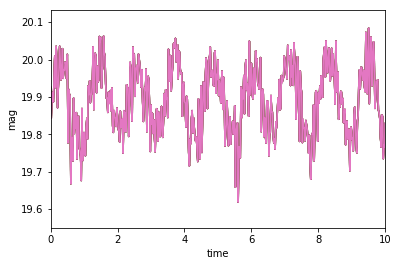

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate pea

In [250]:
# actual frequency = frquency/100
fullGraph([20]*7,87,lower=0,higher=10,ramp=10)
lombScargle([87],([20]*7),Nquist=100,loopNo=1)
 # 40 background corresponing to R band at new moon, could be made more detailed?

In [28]:
PrangeLoop = [(10./(60.*24.)),(20./(60.*24.)),(30./(60.*24.)),(50./(60.*24.)),(60./(60.*24.)),(120./(60.*24.)),(180./(60.*24.)),(240./(60.*24.)),(300./(60.*24.)),(360./(60.*24.)),(0.5),(0.75),(1.),(10.),(20.),(50.),(100.)]
FrangeLoop = [(1/x)*100 for x in PrangeLoop]

In [29]:
fullmeasuredPeriod = [[],[],[],[],[],[]]
fullPeriod = [[],[],[],[],[],[]]
fullPower = [[],[],[],[],[],[]]
fullSigLevel = [[],[],[],[],[],[]]
fullMag = [[],[],[],[],[],[]]
MagRange = np.linspace(17,24,50)
#MagRange = [17,18,19,20,21,22,23,24]
for h in range(0,len(MagRange)):
    lombScargle(FrangeLoop,([MagRange[h]]*7),loopNo=100)
    for x in range(0,len(fullmeasuredPeriod)):
        fullmeasuredPeriod[x].append(totmperiod[x])
        fullPeriod[x].append(totperiod[x])
        fullPower[x].append(totpower[x])
        fullSigLevel[x].append(SigLevel[x])
        fullMag[x].append([MagRange[h]]*len(FrangeLoop))



/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate pea

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

In [ ]:
FilterLabel = ['u','g','r','i','z','y']

for x in range(0,len(fullSigLevel)):
    plt.plot(fullMag[0][0][0],fullPeriod[0][0][0],'bo',label='Sig = 1.0')
    plt.plot(fullMag[0][0][0],fullPeriod[0][0][0],'mo',label='1.0 > Sig > 0.75')
    plt.plot(fullMag[0][0][0],fullPeriod[0][0][0],'co',label='0.75 > Sig > 0.6')
    plt.plot(fullMag[0][0][0],fullPeriod[0][0][0],'yo',label='Sig < 0.6')
    plt.plot(fullMag[0][0][0],fullPeriod[0][0][0],'ro',label='Wrong Period and Sig = 1.0')
    plt.plot(fullMag[0][0][0],fullPeriod[0][0][0],'ko',label='Wrong Period')
    for y in range(0,len(MagRange)):
        for z in range(0,len(FrangeLoop)):
            Label = 0

            if fullmeasuredPeriod[x][y][z] < (fullPeriod[x][y][z]+(fullPeriod[x][y][z]*0.1)) and fullmeasuredPeriod[x][y][z] > (fullPeriod[x][y][z]-(fullPeriod[x][y][z]*0.1)):
                if fullSigLevel[x][y][z] == 1.:
                    colour = 'bo'
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
                elif fullSigLevel[x][y][z] < 1. and fullSigLevel[x][y][z] > 0.75:
                    colour = 'mo'
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
                elif fullSigLevel[x][y][z] < 0.75 and fullSigLevel[x][y][z] > 0.6:
                    colour = 'co'
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
                elif fullSigLevel[x][y][z] < 0.6:
                    colour = 'yo'
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
                    
            else:
                if fullSigLevel[x][y][z] == 1.:
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],'ro')
                else: 
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],'ko')
    plt.xlabel('Magnitude')
    plt.ylabel('Period (days)')
    plt.yscale('log')
    plt.title(FilterLabel[x]+' filter Binary Period Recovery')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

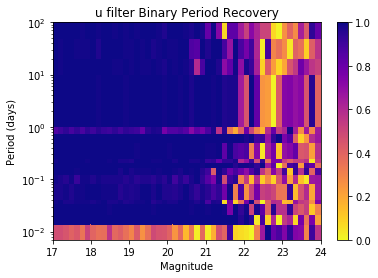

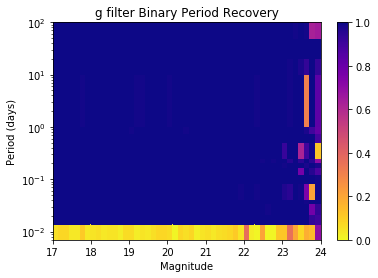

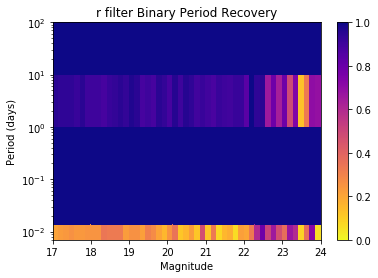

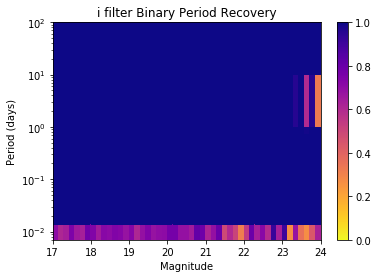

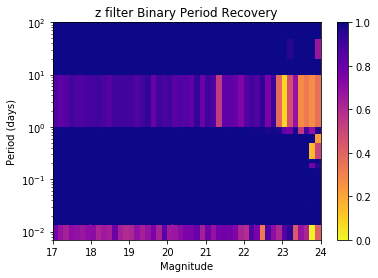

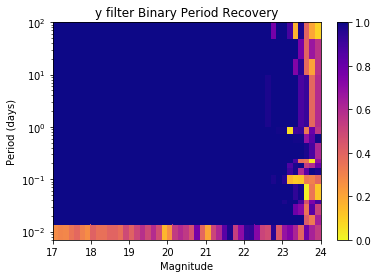

In [30]:
FilterLabel = ['u','g','r','i','z','y']

for x in range(0,len(fullSigLevel)):
    im = plt.pcolor(fullMag[x],fullPeriod[x],fullSigLevel[x],cmap='plasma_r',vmin=0,vmax=1)
    plt.yscale('log')
    plt.colorbar(im)
    #plt.xlim(14,25)
    plt.xlabel('Magnitude')
    plt.ylabel('Period (days)')
    plt.title(FilterLabel[x]+' filter Binary Period Recovery')
    plt.show()

In [309]:
print(fullSigLevel[0])
print(fullPeriod[0])
print(fullMag[0])

[[0.8200000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.79, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.72, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.85, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0], [0.14, 1.0, 1.0, 0.97, 1.0, 0.99, 0.6599999999999999], [0.24, 0.0, 0.83, 0.22999999999999998, 0.95, 0.010000000000000009, 0.37], [0.5700000000000001, 0.47, 0.36, 0.14, 0.41000000000000003, 0.22999999999999998, 0.21999999999999997]]
[[0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0], [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0], [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0], [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0], [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0], [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0], [0.006944444444444444, 0.041666666666666664

In [255]:
fullSigLevel

[[[0.8200000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.79, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.72, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.85, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0],
  [0.14, 1.0, 1.0, 0.97, 1.0, 0.99, 0.6599999999999999],
  [0.24, 0.0, 0.83, 0.22999999999999998, 0.95, 0.010000000000000009, 0.37],
  [0.5700000000000001,
   0.47,
   0.36,
   0.14,
   0.41000000000000003,
   0.22999999999999998,
   0.21999999999999997]],
 [[0.78, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.88, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.84, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.84, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.64, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.72, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.56, 1.0, 1.0, 0.33999999999999997, 0.99, 1.0, 1.0]],
 [[0.47, 1.0, 1.0, 0.590000000000

In [141]:
for x in range(0,len(fullSigLevel)):
    for y in range(0,len(MagRange)):
        plt.scatter(fullMag[x][y],fullPeriod[x][y],c=fullSigLevel[x][y])
for x in range(0,len(fullSigLevel)):
    for y in range(0,len(MagRange)):
        for y in range(0,len(FrangeLoop)):
            if fullmeasuredPeriod[x][y][z] > (fullPeriod[x][y][z]+(fullPeriod[x][y][z]*0.1)) or fullmeasuredPeriod[x][y][z] < (fullPeriod[x][y][z]-(fullPeriod[x][y][z]*0.1)):
                plt.scatter(fullMag[x][y][z],fullPeriod[x][y][z],'ro',label='Wrong Period')
        
                        
    plt.xlabel('Magnitude')
    plt.ylabel('Period (days)')
    plt.yscale('log')
    plt.title('R filter Binary Period Recovery')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [125]:
fullPeriod

[[[0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0]],
 [[0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944

In [128]:
fullPeriod[0][0][0]

0.006944444444444444

In [129]:
x

0

In [130]:
y

0

In [131]:
z

1

In [133]:
fullSigLevel

[[[0.8200000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.79, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.72, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.85, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0],
  [0.14, 1.0, 1.0, 0.97, 1.0, 0.99, 0.6599999999999999],
  [0.24, 0.0, 0.83, 0.22999999999999998, 0.95, 0.010000000000000009, 0.37],
  [0.5700000000000001,
   0.47,
   0.36,
   0.14,
   0.41000000000000003,
   0.22999999999999998,
   0.21999999999999997]],
 [[0.78, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.88, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.84, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.84, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.64, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.72, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [0.56, 1.0, 1.0, 0.33999999999999997, 0.99, 1.0, 1.0]],
 [[0.47, 1.0, 1.0, 0.590000000000

In [142]:
fullMag

[[[15, 15, 15, 15, 15, 15, 15],
  [16, 16, 16, 16, 16, 16, 16],
  [17, 17, 17, 17, 17, 17, 17],
  [18, 18, 18, 18, 18, 18, 18],
  [19, 19, 19, 19, 19, 19, 19],
  [20, 20, 20, 20, 20, 20, 20],
  [21, 21, 21, 21, 21, 21, 21],
  [22, 22, 22, 22, 22, 22, 22],
  [23, 23, 23, 23, 23, 23, 23],
  [24, 24, 24, 24, 24, 24, 24]],
 [[15, 15, 15, 15, 15, 15, 15],
  [16, 16, 16, 16, 16, 16, 16],
  [17, 17, 17, 17, 17, 17, 17],
  [18, 18, 18, 18, 18, 18, 18],
  [19, 19, 19, 19, 19, 19, 19],
  [20, 20, 20, 20, 20, 20, 20],
  [21, 21, 21, 21, 21, 21, 21],
  [22, 22, 22, 22, 22, 22, 22],
  [23, 23, 23, 23, 23, 23, 23],
  [24, 24, 24, 24, 24, 24, 24]],
 [[15, 15, 15, 15, 15, 15, 15],
  [16, 16, 16, 16, 16, 16, 16],
  [17, 17, 17, 17, 17, 17, 17],
  [18, 18, 18, 18, 18, 18, 18],
  [19, 19, 19, 19, 19, 19, 19],
  [20, 20, 20, 20, 20, 20, 20],
  [21, 21, 21, 21, 21, 21, 21],
  [22, 22, 22, 22, 22, 22, 22],
  [23, 23, 23, 23, 23, 23, 23],
  [24, 24, 24, 24, 24, 24, 24]],
 [[15, 15, 15, 15, 15, 15, 15],
  [16